In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import math

In [25]:
import sys, os
script_dir = sys.path[0]
print(script_dir)

DATA_PATH = os.path.join(script_dir+r'\train\train\7554\SimpleTest')
print(DATA_PATH)

C:\Users\eliko\Desktop\Data_science_project\Project\data visualization project\pandas project
C:\Users\eliko\Desktop\Data_science_project\Project\data visualization project\pandas project\train\train\7554\SimpleTest


In [58]:
##Function zone
def plot_images(path):
    counter = 0
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            counter += 1
                
    
    fig, ax = plt.subplots(counter,2)
    fig.set_figheight(150)
    fig.set_figwidth(15)
    index = 0
    
    print("Plotting {0} images".format(counter))
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
#             data = pd.concat([data,temp], axis = 0, ignore_index = True)
            data.dropna(axis = 0, inplace = True)
            data = data.astype({'X' : float})
            data.rename(columns = {" Y" : "Y", 
                                    " Pressure" : "Pressure", 
                                    " TiltX" : "TiltX", 
                                    " TiltY" : "TiltY", 
                                    " Time" : "Time"}, inplace = True)
            
            data['Time']=data['Time'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))
            #Plot picture
            ax[index,0].scatter(data['X'], data['Y'])
            ax[index,0].set_title(f + " (Image)")
            ax[index,0].set_xlabel('X')
            ax[index,0].set_ylabel('Y')
            ax[index,0].set_xlim(data['X'].min()-50, data['X'].max()+50)
            ax[index,0].set_ylim(data['Y'].min()-50, data['Y'].max()+100)
            ax[index,0].invert_yaxis()
            
            #Plot pressure
            ax[index,1].plot(data.index, data['Time'])
            ax[index,1].set_title(f + " (Time)")
            ax[index,1].set_ylabel('Time')
#             ax[1,index].set_xlim(data['X'].min()-50, data['X'].max()+50)
#             ax[1,index].set_ylim(data['Pressure'].min()-50, data['Pressure'].max()+100)
            index += 0
      
def calc_pen_raises(path, time_epsilo):
    result = {}
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
            data.dropna(axis = 0, inplace = True)
            data = data.astype({'X' : float})
            data.rename(columns = {" Y" : "Y", 
                                    " Pressure" : "Pressure", 
                                    " TiltX" : "TiltX", 
                                    " TiltY" : "TiltY", 
                                    " Time" : "Time"}, inplace = True)
            data['Time']=data['Time'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))
            lift_count = 0
            for index in (data.index[:-1]):
                if(data["Time"][index+1] - data["Time"][index] > time_epsilo):
                    lift_count += 1
            result[f.split(".")[0]] = lift_count
    plt.figure(figsize=(15,10))
    plt.bar(range(len(result)), list(result.values()), align='center')
    plt.xlabel("CSV file number")
    plt.ylabel("Number of pen raises")
    plt.grid()
    plt.xticks(range(len(result)), list(result.keys()))
    
def calc_lines1(path):
    result = {}
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
            data.dropna(axis = 0, inplace = True)
            data = data.astype({'X' : float})
            data.rename(columns = {" Y" : "Y", 
                                    " Pressure" : "Pressure", 
                                    " TiltX" : "TiltX", 
                                    " TiltY" : "TiltY", 
                                    " Time" : "Time"}, inplace = True)
            
            dot_count = 0
            pressure_sum = 0
            length = 0
            properties = {}
            line_count = 0
            property_list = []
            for index in (data.index[:-1]):
                if((data["TiltX"][index] == data["TiltX"][index+1]) and (data["TiltY"][index] == data["TiltY"][index+1])):
                    flag = True #Is a part of a line
                    dot_count += 1
                    pressure_sum += data['Pressure'][index]
                    length += math.sqrt(math.pow(data["X"][index] - data["X"][index+1],2) + math.pow(data["Y"][index] - data["Y"][index+1],2))
                else:
                    if(flag and (length >= 50)):
                        dot_count += 1
                        pressure_sum += data['Pressure'][index]
                        pressure_avg = pressure_sum / dot_count
                        line_count += 1
                        property_list.append(pressure_avg)
                        property_list.append(length)
                        properties[line_count] = property_list
                    dot_count = 0
                    pressure_sum = 0
                    length = 0
                    property_list = []
                    flag = False
            result[f.split(".")[0]] = properties
            
    pprint.pprint(result)    

In [59]:
calc_lines1(DATA_PATH)

{'1': {1: [0.2579465018851416, 55.189388802709054],
       2: [0.36349126994609815, 56.888674612054984]},
 '10': {1: [0.5793968741342707, 133.50593326496025],
        2: [0.35814871305021745, 52.93320890389416],
        3: [0.5246361491806579, 52.75880718980761],
        4: [0.3659338681470781, 72.81928632050189],
        5: [0.45341311262122225, 70.88356212959765],
        6: [0.5446402664695467, 91.75122328398437],
        7: [0.3768449213276518, 205.57459662269892]},
 '11': {1: [0.7134647654450458, 111.40460027899675],
        2: [0.7268408392156873, 71.1200890499009],
        3: [0.42000458016991626, 55.62431226294576]},
 '12': {1: [0.32138721203362514, 163.7942843629477],
        2: [0.5086784862809712, 82.54237684532629],
        3: [0.4757106221564437, 61.16968520661422],
        4: [0.7258259057998658, 52.03282712139114]},
 '13': {1: [0.3132300799091656, 122.98833590308091],
        2: [0.21846025668341537, 50.65941396006942],
        3: [0.4065176407496135, 71.93108446854627],

In [43]:
# data = pd.read_csv(data_path)

Plotting 21 images


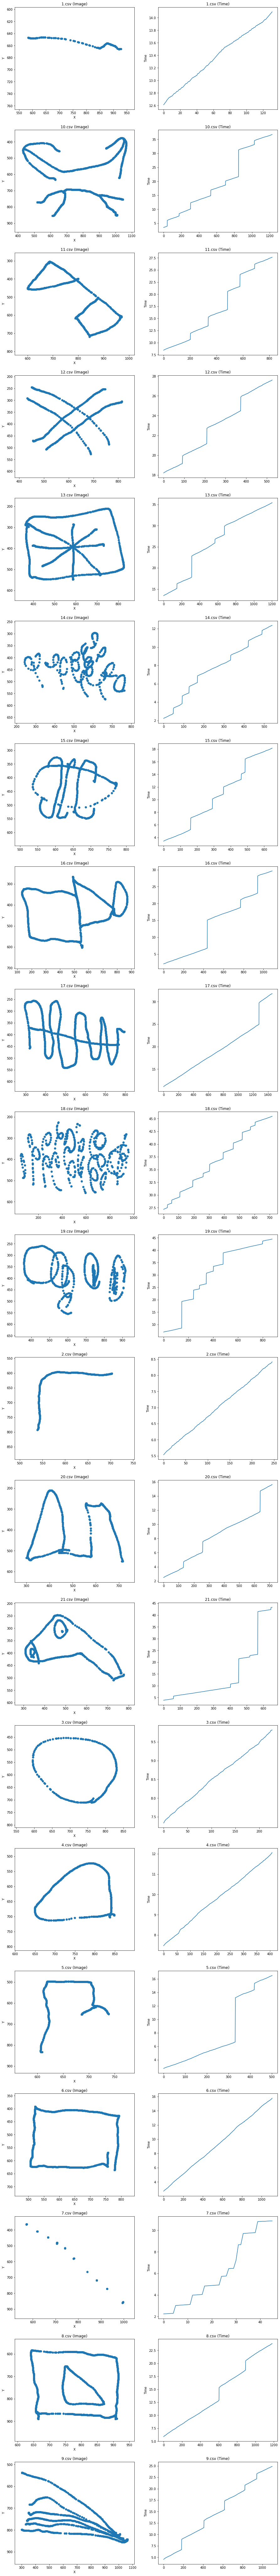

In [10]:
plot_images(DATA_PATH)

In [45]:
# less_data = data.iloc[:-2,:]
# less_data

,X,Y,Pressure,TiltX,TiltY,Time
0,925.902760133965,665.541979,0.045884,-4917.0,669.0,00:12.6099853
1,925.902760133965,665.541979,0.045884,-4917.0,669.0,00:12.6256038
2,926.692689687031,665.647303,0.082506,-4917.0,669.0,00:12.6445684
3,927.008661508257,665.647303,0.115953,-4917.0,669.0,00:12.6602735
4,927.324633329484,665.594641,0.140368,-4917.0,669.0,00:12.6838147
...,...,...,...,...,...,...
127,585.495784732648,647.004966,0.378408,-4510.0,1946.0,00:14.0316787
128,584.863841090195,646.846980,0.382803,-4510.0,1946.0,00:14.0472865
129,584.863841090195,646.846980,0.386954,-4510.0,1946.0,00:14.0629098
130,584.653193209377,646.741656,0.386954,-4501.0,1991.0,00:14.0785335


(0.0, 889.934634484351)

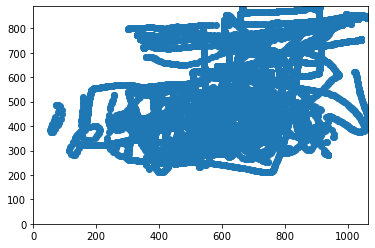

In [113]:
plt.scatter(data['X'], data['Y'])
plt.xlim(0,data['X'].max())
plt.ylim(0,data['Y'].max())